# DS 1005 Hwk 3 - Belief Propagation

## Q1 - Sum-product algorithm 

In [1]:
import numpy as np 
import pandas as pd
import networkx as nx
from fglib import graphs, nodes, rv, inference, utils
from pyldpc import RegularH, CodingMatrixG # old version of API
from itertools import product
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
dist_f3 = [0.5, 0.5]
dist_f4 = [0.4,0.6]
px3x4=np.outer(dist_f3,dist_f4)
print(px3x4)
print(px3x4.shape)
px3x4=np.reshape(px3x4, np.shape(px3x4)+(1,))
print(px3x4)
print(px3x4.shape)
px2_conditioned_x3x4=[[[0.2,0.8],
                     [0.25,0.75],],
                     [[0.7,0.3],
                     [0.3,0.7]]]
print(px2_conditioned_x3x4)
dist_f234 =px3x4*px2_conditioned_x3x4
print(dist_f234)
print(dist_f234.shape)
px2= np.sum(dist_f234, axis=(0,1))
print(px2)
px1_conditioned_x2 = [[0.5,0.5],
                     [0.7,0.3]]
dist_f12 =px2[:,np.newaxis]*px1_conditioned_x2
print(dist_f12)
print(dist_f12.shape)

[[0.2 0.3]
 [0.2 0.3]]
(2, 2)
[[[0.2]
  [0.3]]

 [[0.2]
  [0.3]]]
(2, 2, 1)
[[[0.2, 0.8], [0.25, 0.75]], [[0.7, 0.3], [0.3, 0.7]]]
[[[0.04  0.16 ]
  [0.075 0.225]]

 [[0.14  0.06 ]
  [0.09  0.21 ]]]
(2, 2, 2)
[0.345 0.655]
[[0.1725 0.1725]
 [0.4585 0.1965]]
(2, 2)


In [3]:
def make_debug_graph():

    # Create factor graph
    fg = graphs.FactorGraph()

    # Create variable nodes
    x1 = nodes.VNode("x1", rv.Discrete)
    x2 = nodes.VNode("x2", rv.Discrete)
    x3 = nodes.VNode("x3", rv.Discrete)
    x4 = nodes.VNode("x4", rv.Discrete)

    # Create factor nodes
    f12 = nodes.FNode("f12")
    f234 = nodes.FNode("f234")
    f3 = nodes.FNode("f3")
    f4 = nodes.FNode("f4")

    # Add nodes to factor graph
    fg.set_nodes([x1, x2, x3, x4])
    fg.set_nodes([f12, f234, f3,f4 ])

    # Add edges to factor graph
    fg.set_edge(x1, f12)
    fg.set_edge(f12, x2)
    fg.set_edge(x2, f234)
    fg.set_edge(f234, x3)
    fg.set_edge(f234, x4)
    fg.set_edge(x3, f3)
    fg.set_edge(x4, f4)

    #add potential for f_3: p(x3)
    dist_f3 = [0.5, 0.5]
    f3.factor = rv.Discrete(dist_f3,x3)
    
    #add potential for f_4: p(x4)
    dist_f4 = [0.4,0.6]
    f4.factor = rv.Discrete(dist_f4,x4)
    
    # add potential for f_{234}: p(x2, x3, x4) = p(x2|x3,x4) p(x3,x4)
    px3x4=np.outer(dist_f3,dist_f4)
    px3x4=np.reshape(px3x4, np.shape(px3x4)+(1,))
    px2_conditioned_x3x4=[[[0.2,0.8],
                         [0.25,0.75],],
                         [[0.7,0.3],
                         [0.3,0.7]]]
    
    dist_f234 =px3x4*px2_conditioned_x3x4
    f234.factor = rv.Discrete(dist_f234,x3,x4,x2)
   
    # add potential for f_{12}:  p (x1,x2) = p(x1 | x2) p(x2)
    px1_conditioned_x2 = [[0.5,0.5],
                         [0.7,0.3]]
    px2= np.sum(dist_f234, axis=(0,1))
    dist_f12 =px2[:,np.newaxis]*px1_conditioned_x2
    f12.factor = rv.Discrete(dist_f12,x2,x1)
    # Perform sum-product algorithm on factor graph
    # and request belief of variable node x1
    
    belief = inference.sum_product(fg, x1)
    print(belief)
    return (fg)


### 1a. Implement sum-product algorithm 

In [4]:
def get_beliefs_at_iter(beliefs_hist, iter_num):
    
    """ Retrieves beliefs at a given iteration. 
    
    Parameters
    ----------
    beliefs_hist: dict
        A log of beliefs after each iteration of loopy belief propagation, represented by {k:v} where k is 
        iteration number and v is a nested dictionary representing beliefs at that iteration 
    iter_num: int
        Iteration number at which to retrieve beliefs 
        
    Returns
    -------
    beliefs_at_iter: dict 
        A dictionary of beliefs at iter_num {k1:v1}, where k1 is variable node and v1 is the node's beliefs,
        represented by their probability mass functions 
    """
    
    beliefs_at_iter = {}
    for v in beliefs_hist: 
        beliefs_at_iter[v] = beliefs_hist[v][iter_num]
    return beliefs_at_iter 

def get_beliefs(model, n_iter=10):
    
    """ Runs loopy belief propagation (sum-product) algorithm through a factor graph model 
    
    Parameters
    ----------
    model: object 
        An instance of FactorGraph class in fglib library. 
    n_iter: int
        Number of iterations to run loopy belief propagation 
        
    Returns
    -------
    beliefs: dict    
        A dictionary of beliefs after the last iteration of loopy belief propagation 
    
    beliefs_hist: dict of dicts 
        A log of beliefs after each iteration of loopy belief propagation, represented by {k:v} where k is 
        iteration number and v is a nested dictionary representing beliefs at that iteration 

    """
    
    beliefs_hist = {v:[] for v in model.get_vnodes()}
    
    # initialize variable to factor messages 
    for v in model.get_vnodes():
        for f in v.neighbors():
            initial_msg = rv.Discrete(np.ones(2,), v)
            model[v][f]['object'].set_message(v, f, initial_msg.normalize())

    # run parallel updates for n_iter times 
    for i in range(n_iter):
        
        # update factor-to-variable messages
        for f in model.get_fnodes():
            for v in f.neighbors():
                msg = f.factor 
                for n in f.neighbors(exclusion=v):
                    msg *= model[n][f]['object'].get_message(n, f)
                    msg = msg.normalize()
                for n in f.neighbors(exclusion=v):
                    msg = msg.marginalize(n, normalize=True)
                model[f][v]['object'].set_message(f, v, msg.normalize())
                
        # update variable-to-factor messages 
        for v in model.get_vnodes(): 
            for f in v.neighbors():
                msg = rv.Discrete(np.ones(2,), v)
                for n in v.neighbors(exclusion=f):
                    msg *= model[n][v]['object'].get_message(n, v)
                    msg = msg.normalize()
                model[v][f]['object'].set_message(v, f, msg.normalize())

        # store beliefs of variable nodes 
        for v in model.get_vnodes():
            belief = rv.Discrete(np.ones(2,), v)
            for n in v.neighbors():
                belief *= model[n][v]['object'].get_message(n, v)
            beliefs_hist[v].append(belief.normalize())
            
    beliefs = get_beliefs_at_iter(beliefs_hist, n_iter-1)
    
    return beliefs, beliefs_hist

def print_beliefs(beliefs):
    
    """ Print out beliefs at each variable node 
    
    Parameters
    ----------
    beliefs: dict 
        A dictionary of beliefs represented by {k:v}, where k is a variable node and v its corresponding PMF  
        
    Returns
    -------
    None. Prints out beliefs, one line per variable node.  
    """
    
    for (v,b) in beliefs.items():
        print(v, b)

### 1b. Test on 4-node factor graph provided 

In [5]:
fg = make_debug_graph()
beliefs, _ = get_beliefs(fg)
print_beliefs(beliefs)

[0.65897284 0.34102716]
x1 [0.65897284 0.34102716]
x2 [0.20513578 0.79486422]
x3 [0.52640912 0.47359088]
x4 [0.28679718 0.71320282]


## Q2 - Low-Density Priority Check (LDPC)

### Part a:  

In [6]:
def get_factor_potentials(d_v): # where d_v = num of variable nodes in parity check equation 
    """ Build N-dimensional factor potential to represent a parity check equation  

    Parameters
    ----------
    d_v: int 
        Number of dimensions in factor potential, aka # of variable nodes per partiy check equation 
        
    Returns
    -------
    phi: np.array
        N-dimentional factor potential representing the parity check equation. Indices of array represent possible
        permutations of binary values {0,1} across dimensions, and phi=1 iff sum of indices is divisible by 2 
        (i.e. passes parity check), and phi=0 otherwise (i.e. fails parity check)
    """
    
    permutations = product([0,1], repeat=d_v)
    phi = np.zeros([2 for i in range(d_v)])
    for idx in permutations:
        if sum(idx) % 2 == 0: 
            phi[idx] = 1
        else:
            phi[idx] = 0
    return phi 

In [7]:
def make_ldpc_fg(H):
    """ Given an arbitrary parity check matrix create a corresponding factor graph 
    
    Parameters
    ----------
    H: np.array
        MxN parity check matrix where M = # of parity check equations and N = # of variable nodes 
        
    Returns
    -------
    fg: object 
        An instantiation of the FactorGraph class in fglib library, representing the LDPC graph that will 
        be used for decoding messages         
    """
    
    # initialize factor graph  
    fg = graphs.FactorGraph()
    
    # infer the number of factor and variable nodes required
    num_factors, num_variables = H.shape

    # create factor nodes 
    fnodes = [] 
    for i in range(num_factors):
        fnodes.append(nodes.FNode("f" + str(i)))
    
    # create variable nodes 
    vnodes = [] 
    for j in range(num_variables):
        vnodes.append(nodes.VNode("x" + str(j), rv.Discrete))
        
    # add nodes to factor graph 
    fg.set_nodes(vnodes)
    fg.set_nodes(fnodes)
    
    # add edges to factor graph based on H 
    for i in range(num_factors):
        for j in range(num_variables):
            if H[i,j] == 1:
                fg.set_edge(fnodes[i], vnodes[j])
                
    # set factor potentials 
    for fnode in fg.get_fnodes():
        vnodes2check = [vnode for vnode in fnode.neighbors()]
        fnode_potentials = get_factor_potentials(len(vnodes2check))
        fnode.factor = rv.Discrete(fnode_potentials, *vnodes2check)
        
    return fg

In [8]:
def evaluate_prob(model, codeword):
    """ Evaluate the unnormalized probability of a given codeword under a LDPC graphical model 

    Parameters
    ----------
    model: object
        MxN parity check matrix where M = # of parity check equations and N = # of variable nodes 
    codeword: np.array
        Message represented by an array of binary values to be evaluated
        
    Returns
    -------
    prob: float 
        Unnormalized probability of a given codeword under the LDPC graphical model 
        In our use case, this evaluates to 0 if the codeword fails parity checks, and 1 if it passes 
    """
    
    prob = 1
    for f in model.get_fnodes():
        v_checked = [int(str(v)[1:]) for v in f.neighbors()]
        idx = tuple([codeword[i] for i in v_checked])
        prob *= f.factor.pmf[idx]
    return prob

In [9]:
# create parity check matrix (note d_v = ones per column, d_c = ones per row)
H = RegularH(n=8, d_v=2, d_c=4)
print(H)
ldpc_fg = make_ldpc_fg(H)

[[1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1]
 [0 1 1 0 1 0 1 0]
 [1 0 0 1 0 1 0 1]]


In [10]:
# define invalid codewords 
invalid_code = np.array([1, 0, 0, 0, 0, 0, 0, 0]) # should fail parity check 
print("Given H = {}, this code is expected to fail parity check: {}".format(H, invalid_code))
prob = evaluate_prob(ldpc_fg, invalid_code)
print("Prob is {}".format(prob))

Given H = [[1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1]
 [0 1 1 0 1 0 1 0]
 [1 0 0 1 0 1 0 1]], this code is expected to fail parity check: [1 0 0 0 0 0 0 0]
Prob is 0.0


In [11]:
# zero should pass 
valid_code = np.zeros(8, dtype=int)
print("Zeros should always pass parity check: {}".format(valid_code))
prob = evaluate_prob(ldpc_fg, valid_code)
print("Prob is {}".format(prob))

Zeros should always pass parity check: [0 0 0 0 0 0 0 0]
Prob is 1.0


### Part b: 128-bit LDPC

In [12]:
def get_unary_potential(obs, err):
    """ Build unary potential of a variable node based on observed data
    
    Parameters
    ----------
    obs: int
        Observed bit (either 0 or 1) at variable node of interest 
    err: float
        Assumed error rate of the binary symmetric channel  
        
    Returns
    -------
    phi: np.array
        Unary potential of the variable node, represented by an array of two values, which are the respective
        probabilities that the node might take on value of 0 vs. 1, given the observation and error rate  
    """
    
    phi = np.zeros(shape=(2,))
    phi[obs] = 1 - err 
    phi[1-obs] = err 
    return phi 

def set_unary_factors(fg, msg, err):
    """ Adds unary factors to a LDPC factor graph 

    Parameters
    ----------
    fg: object
        An instantiation of the FactorGraph class in fglib library, representing the LDPC graphical model 
        *before* unary factors are added 
    msg: np.array
        Message received, represented by an array of binary values 
    err: float 
        Assumed error rate of the binary symmetric channel  
        
    Returns
    -------
    fg: object 
        An instantiation of the FactorGraph class in fglib library, representing the LDPC graphical model 
        *after* unary factors are added 
    """
    
    for vnode in fg.get_vnodes():
        idx = int(str(vnode)[1:])
        phi = get_unary_potential(msg[idx-1], err)
        ufnode = nodes.FNode("u" + str(idx))
        ufnode.factor = rv.Discrete(phi, vnode)
        fg.set_node(ufnode)
        fg.set_edge(ufnode, vnode)
    return fg

# def transmit(original, err):
#     is_flipped = np.random.rand(len(original)) < err
#     transmitted = np.where(is_flipped, 1 - original, original)
#     return transmitted

def add_noise(original, err):
    """ Adds noise to simulate output of a binary symmetric channel  
    
    Parameters
    ----------
    original: np.array
        Original message transmitted, represented by an array of binary bits  
    err: float 
        Assumed error rate of the binary symmetric channel  
        
    Returns
    -------
    received: np.array 
        Message received as output of binary symmetric channel, i.e. after error was introduced 
    """
    
    is_flipped = np.random.rand(len(original)) < err
    received = np.where(is_flipped, 1 - original, original)
    return received

def decode_msg(beliefs):

    """ Decodes message by setting each bit to the maximum of posterior marginal beliefs 
    
    Parameters
    ----------
    beliefs: dict
        A dictionary of beliefs represented by {k:v}, where k is a variable node and v its corresponding PMF  
        
    Returns
    -------
    decoded: np.array 
        Decoded message 
    """
    
    decoded = np.zeros(len(beliefs))
    for v in beliefs:
        pos = int(str(v)[1:]) 
        decoded[pos] = np.asscalar(np.argmax(beliefs[v].pmf))
    return decoded 

def hamming_dist(source, decoded):
    
    """ Computes hamming instance between the source message and decoded message 
    
    Parameters
    ----------
    source: np.array
        Source message, represented an array of binary bits 
    decoded: np.array
        Decoded message, represented an array of binary bits          
        
    Returns
    -------
    hdist: int 
        Hamming distance between source and decoded messages, defined as number of differing bits 
    """
    
    return np.sum(source != decoded)

In [13]:
def run_experiment(source, err, n_iter, d_v=4, d_c=8):
    
    """ Simulate transmission of a source message through a binary symmetric channel then 
        run loopy belief propagation to decode the received message 
        
    Parameters
    ----------
    source: np.array
        Source message, represented an array of binary bits 
    err: float 
        Assumed error rate of the binary symmetric channel  
    n_iter: int
        Number of iterations to run loopy belief propagation 
    d_v: int (default 4)
        Number of variable nodes checked in each parity check equation 
    d_c: int (default 8)
        Number of parity check equations 
        
    Returns
    -------
    hdist: int 
        Hamming distance between source and decoded messages, defined as number of differing bits 
    beliefs: dict    
        A dictionary of beliefs after the last iteration of loopy belief propagation 
    beliefs_hist: dict of dicts 
        A log of beliefs after each iteration of loopy belief propagation, represented by {k:v} where k is 
        iteration number and v is a nested dictionary representing beliefs at that iteration 
    decoded: np.array
        Decoded message, represented an array of binary bits          
    """
    
    # add noise to msg transmitted 
    received = add_noise(source, err)
    
    # create factor graph model used to decode message (SHOULD THIS BE REFACTORED?)
    H = RegularH(len(source), d_v, d_c)
    ldpc_fg = make_ldpc_fg(H)
    ldpc_fg = set_unary_factors(ldpc_fg, received, err)
    
    # run loopy belief propagation 
    beliefs, beliefs_hist = get_beliefs(ldpc_fg, n_iter)
    
    # decode message and compute distance 
    decoded = decode_msg(beliefs)
    hdist = hamming_dist(source, decoded)
    
    return hdist, beliefs, beliefs_hist, decoded

In [14]:
source = np.zeros(256, dtype=int)
hdist, beliefs, beliefs_hist, decoded = run_experiment(source, .05, 50)

In [15]:
hdist

0

In [16]:
decoded

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Part C 

In [37]:
def evaluate_at_iter(beliefs_hist, source, iter_num):
    """ Given a log of beliefs, decode and evaluate hamming distance at a given iteration 
    
    Parameters
    ----------
    beliefs_hist: dict of dicts 
        A log of beliefs after each iteration of loopy belief propagation, represented by {k:v} where k is 
        iteration number and v is a nested dictionary representing beliefs at that iteration 
    original: np.array
        Source message, represented an array of binary bits     
    iter_num: int 
        Iteration number at which to retrieve beliefs 
    
    Returns
    -------
    hdist: int 
        Hamming distance between source and decoded messages, defined as number of differing bits 
    decoded: np.array
        Decoded message, represented an array of binary bits              

    """
    
    beliefs_at_iter = get_beliefs_at_iter(beliefs_hist, iter_num)
    decoded = decode_msg(beliefs_at_iter)
    hdist = hamming_dist(source, decoded)
    
    return hdist, decoded 

In [44]:
def plot_results(results, err, n_trials):
    
    """ Plots Hamming distance curves (by iteration) for N random trials 
    
    Parameters
    ----------
    results: list of dictionaries 
        Each dictionary stores the Hamming distance (value) at each iteration (key) for a given trial 
    err: float 
        Assumed error rate of the binary symmetric channel  
    n_trials: int
        Number of random trials 
    
    Returns
    -------
    hdist: int 
        Hamming distance between source and decoded messages, defined as number of differing bits 
    decoded: np.array
        Decoded message, represented an array of binary bits              
    
    
    """
    n_trials = len(results)
    pd.DataFrame(results).T.plot(figsize=(10,5), legend=None)
    plt.ylabel('Hamming distance')
    plt.xlabel('Iteration')
    plt.title('Hamming distance versus iteration with err={} for {} random trials'.format(err, n_trials))

In [45]:
def run_experiments(err, n_trials, source, n_iter, d_v=4, d_c=8):
    
    """ Repeat experiment (simulate transmission of a source message through a BSC then run loopy BP to decode 
    the received message) for multiple trials and return hamming distance at each iteration for each trial 

    Parameters
    ----------
    err: float
        Assumed error rate of the binary symmetric channel  
    n_trials: int 
        Number of times to repeat experiment 
    source: np.array
        Source message, represented an array of binary bits 
    n_iter: int
        Number of iterations to run loopy belief propagation 
    d_v: int (default 4)
        Number of variable nodes checked in each parity check equation 
    d_c: int (default 8)
        Number of parity check equations 
    
    Returns
    -------
    results: list of dictionaries 
        Each dictionary stores the Hamming distance (value) at each iteration (key) for a given trial 
    plot: 
        Hamming distance vs. Iteration
    """
    
    results = []  
    
    for trial_num in range(n_trials):
        hdist, beliefs, beliefs_hist, decoded = run_experiment(source, err, n_iter, d_v, d_c)
        
        result = {} 
        for iter_num in range(n_iter):
            hdist, _ = evaluate_at_iter(beliefs_hist, source, iter_num)
            result[iter_num+1] = hdist # record results as 1-indexed
        results.append(result)
        
    plot_results(results, err, n_trials)
    
    return results

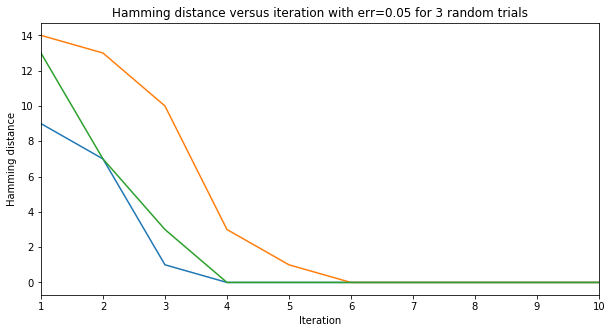

In [46]:
# test 
zero_msg = np.zeros(256, dtype=int)
results = run_experiments(err=0.05, n_trials=3, source=zero_msg, n_iter=10, d_v=4, d_c=8)

In [ ]:
zero_msg = np.zeros(256, dtype=int)
results = run_experiments(err=0.05, n_trials=10, source=zero_msg, n_iter=50, d_v=4, d_c=8)

### Part D

In [ ]:
results_err8 = run_experiments(err=0.08, n_trials=10, source=zero_msg, n_iter=50, d_v=4, d_c=8)
#results_err8 = run_experiments(err=0.08, n_trials=10, n_iter=50, msg_len=256, d_v=4, d_c=8)

In [ ]:
results_err10 = run_experiments(err=0.10, n_trials=10, source=zero_msg, n_iter=50, d_v=4, d_c=8)
#results_err10 = run_experiments(err=0.10, n_trials=10, n_iter=50, msg_len=256, d_v=4, d_c=8)

### Part E 

In [ ]:
# from latest version of the library 

import math
import numpy as np
import scipy
from scipy.stats import norm
from scipy.sparse import csr_matrix
pi = math.pi


def int2bitarray(N, k):
    """
    Changes array's base from int (base 10) to binary (base 2)
    Parameters:
    ===========
    N: int N
    k: Width of the binary array you would like to change N into.
    N must not be greater than 2^k - 1.
    >> Examples: int2bitarray(6,3) returns [1, 1, 0]
                 int2bitarray(6,5) returns [0, 0, 1, 1,0]
                 int2bitarray(255,8) returns [1, 1, 1, 1, 1, 1, 1, 1]
                 int2bitarray(255,10) returns [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
    """

    binary_string = bin(N)
    length = len(binary_string)
    bitarray = np.zeros(k, 'int')
    for i in range(length-2):
        bitarray[k-i-1] = int(binary_string[length-i-1])

    return bitarray


def bitarray2int(bitarray):

    """ Changes array's base from binary (base 2) to int (base 10).
    Parameters:
    ===========
    bitarray: Binary Array.
    >> Examples: bitarray2int([1, 1, 0]) returns 6
                 bitarray2int([0, 0, 1, 1,0]) returns 6
                 bitarray2int([1, 1, 1, 1, 1, 1, 1, 1]) returns 255
    """

    bitstring = "".join([str(i) for i in bitarray])

    return int(bitstring, 2)


def binaryproduct(X, Y):

    """ Binary Matrices or Matrix-vector product in Z/2Z.
    Works with scipy.sparse.csr_matrix matrices X, Y too."""

    A = X.dot(Y)

    if type(A) != scipy.sparse.csr_matrix:
        return A % 2

    return A.toarray() % 2


def gaussjordan(X, change=0):

    """
    Description:
    Performs the row reduced echelon form of X and returns it.
    If change = 1, all changes in the X's rows are applied to
    identity matrix P:
    Let A be our parameter X. refA the reduced echelon form of A.
    P is the square invertible matrix:
    P.A = Aref.
    -------------------------------------------------
    Parameters:
    X: 2D-Array.
    change : boolean (default = 0)
    ------------------------------------------------
    change = 0  (default)
     >>> Returns 2D-Array Row Reduced Echelon form of Matrix
    change = 1
    >>> Returns Tuple of 2D-arrays (refX, P) where P is described above.
    """

    A = np.copy(X)
    m, n = A.shape

    if change:
        P = np.identity(m).astype(int)

    pivot_old = -1
    for j in range(n):
        filtre_down = A[pivot_old+1:m, j]
        pivot = np.argmax(filtre_down)+pivot_old+1

        if A[pivot, j]:
            pivot_old += 1
            if pivot_old != pivot:
                aux = np.copy(A[pivot, :])
                A[pivot, :] = A[pivot_old, :]
                A[pivot_old, :] = aux
                if change:
                    aux = np.copy(P[pivot, :])
                    P[pivot, :] = P[pivot_old, :]
                    P[pivot_old, :] = aux

            for i in range(m):
                if i != pivot_old and A[i, j]:
                    if change:
                        P[i, :] = abs(P[i, :]-P[pivot_old, :])
                    A[i, :] = abs(A[i, :]-A[pivot_old, :])

        if pivot_old == m-1:
            break

    if change:
        return A, P
    return A


def binaryrank(X):
    """ Computes rank of a binary Matrix using Gauss-Jordan algorithm"""
    A = np.copy(X)
    m, n = A.shape

    A = gaussjordan(A)

    return sum([a.any() for a in A])


def f1(y, sigma):
    """ Normal Density N(1,sigma) """
    f = norm.pdf(y, loc=1, scale=sigma)
    return f


def fm1(y, sigma):
    """ Normal Density N(-1,sigma) """

    f = norm.pdf(y, loc=-1, scale=sigma)
    return f


def bits2i(H, i):
    """
    Computes list of elements of N(i)-j:
    List of variables (bits) connected to Parity node i.
    """
    if type(H) != scipy.sparse.csr_matrix:
        m, n = H.shape
        return list(np.where(H[i])[0])

    indj = H.indptr
    indi = H.indices

    return [indi[a] for a in range(indj[i], indj[i+1])]


def nodes2j(H, j):

    """
    Computes list of elements of M(j):
    List of nodes (PC equations) connecting variable j.
    """

    return bits2i(H.T, j)


def bitsandnodes(H):

    m, n = H.shape

    bits = [bits2i(H, i) for i in range(m)]
    nodes = [nodes2j(H, j)for j in range(n)]

    return bits, nodes


def incode(H, x):

    """ Computes Binary Product of H and x. If product is null, x is in the code.
        Returns appartenance boolean.
    """

    return (binaryproduct(H, x) == 0).all()


def gausselimination(A, b):

    """ Applies Gauss Elimination Algorithm to X in order to solve a
    linear system X.X = B. X is transformed to row echelon form:
         |1 * * * * * |
         |0 1 * * * * |
         |0 0 1 * * * |
         |0 0 0 1 * * |
         |0 0 0 0 1 * |
         |0 0 0 0 0 1 |
         |0 0 0 0 0 0 |
         |0 0 0 0 0 0 |
         |0 0 0 0 0 0 |
    Same row operations are applied on 1-D Array vector B.
    Both arguments are sent back.
    --------------------------------------
    Parameters:
    X: 2D-array.
    B:      1D-array. Size must equal number of rows of X.
    -----------------------------------
    Returns:
    Modified arguments X, B as described above.
         """
    if type(A) == scipy.sparse.csr_matrix:
        A = A.toarray().copy()
    else:
        A = A.copy()
    b = b.copy()
    n, k = A.shape

    for j in range(min(k, n)):
        listedepivots = [i for i in range(j, n) if A[i, j]]
        if len(listedepivots):
            pivot = np.min(listedepivots)
        else:
            continue
        if pivot != j:
            aux = (A[j, :]).copy()
            A[j, :] = A[pivot, :]
            A[pivot, :] = aux

            aux = b[j].copy()
            b[j] = b[pivot]
            b[pivot] = aux

        for i in range(j+1, n):
            if A[i, j]:
                A[i, :] = abs(A[i, :]-A[j, :])
                b[i] = abs(b[i]-b[j])

    return A, b

def coding_matrix_systematic(X, sparse=True):

    """
    Description:
    Solves H.G' = 0 and finds the coding matrix G in the systematic form :
    [I_k  A] by applying permutations on X.
    CAUTION: RETURNS TUPLE (Hp,tGS) WHERE Hp IS A MODIFIED VERSION OF THE
    GIVEN PARITY CHECK X, tGS THE TRANSPOSED
    SYSTEMATIC CODING X ASSOCIATED TO Hp. YOU MUST USE THE RETURNED TUPLE
    IN CODING AND DECODING, RATHER THAN THE UNCHANGED
    PARITY-CHECK X H.
    -------------------------------------------------
    Parameters:
    X: 2D-Array. Parity-check matrix.
    sparse: (optional, default True): use scipy.sparse matrices
    to speed up computation if n>100.
    ------------------------------------------------
    >>> Returns Tuple of 2D-arrays (Hp,GS):
        Hp: Modified H: permutation of columns (The code doesn't change)
        tGS: Transposed Systematic Coding matrix associated to Hp.
    """

    H = X.copy()
    m, n = H.shape

    if n > 100 and sparse:
        sparse = True
    else:
        sparse = False

    P1 = np.identity(n, dtype=int)

    Hrowreduced = gaussjordan(H)

    k = n - sum([a.any() for a in Hrowreduced])

    # After this loop, Hrowreduced will have the form H_ss : | I_(n-k)  A |

    while(True):
        zeros = [i for i in range(min(m, n)) if not Hrowreduced[i, i]]
        indice_colonne_a = min(zeros)
        list_ones = [j for j in range(indice_colonne_a+1, n)
                     if Hrowreduced[indice_colonne_a, j]]
        if not len(list_ones):
            break

        indice_colonne_b = min(list_ones)

        aux = Hrowreduced[:, indice_colonne_a].copy()
        Hrowreduced[:, indice_colonne_a] = Hrowreduced[:, indice_colonne_b]
        Hrowreduced[:, indice_colonne_b] = aux

        aux = P1[:, indice_colonne_a].copy()
        P1[:, indice_colonne_a] = P1[:, indice_colonne_b]
        P1[:, indice_colonne_b] = aux

    # NOW, Hrowreduced has the form: | I_(n-k)  A | ,
    # the permutation above makes it look like :
    # |A  I_(n-k)|

    P1 = P1.T
    identity = list(range(n))
    sigma = identity[n-k:] + identity[:n-k]

    P2 = np.zeros(shape=(n, n), dtype=int)
    P2[identity, sigma] = np.ones(n)

    if sparse:
        P1 = csr_matrix(P1)
        P2 = csr_matrix(P2)
        H = csr_matrix(H)

    P = binaryproduct(P2, P1)

    if sparse:
        P = csr_matrix(P)

    Hp = binaryproduct(H, np.transpose(P))

    GS = np.zeros((k, n), dtype=int)
    GS[:, :k] = np.identity(k)
    GS[:, k:] = (Hrowreduced[:n-k, n-k:]).T

    return Hp, GS.T

In [ ]:
def load_image(img_filepath):
    img = cv2.imread(img_filepath,2)
    img = cv2.resize(img, (40, 40))
    ret, bw_img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    img_code = (bw_img / 255).astype(int)
    img_code_flattened = img_code.flatten()
    return img_code_flattened 

def show_image(binary_code):
    code_reshaped = binary_code.reshape((40,40))
    plt.imshow(code_reshaped)

In [ ]:
img = load_image('binary-image.png')
show_image(img)

In [ ]:
#H_ = RegularH(n=256, d_v=64, d_c=128)
H_ = RegularH(n=3200, d_v=4, d_c=8)
H, Gt = coding_matrix_systematic(H_)
print("Shape of H: {}".format(H.shape))
print("Shape of Gt: {}".format(Gt.shape))

In [ ]:
print("Shape of img: {}".format(img.shape))

In [ ]:
img_padded = np.concatenate([img, np.zeros(3)])
print("Shape of img padded: {}".format(img_padded.shape))
t = Gt @ img_padded
print("Shape of t: {}".format(t.shape))
r = add_noise(t, .05)
print("Shape of r: {}".format(r.shape))

In [ ]:
show_image(r[:1600])

In [ ]:
def encode_img(img):
    H_ = RegularH(n=3200, d_v=4, d_c=8)
    H, Gt = coding_matrix_systematic(H_)
    img_padded = np.concatenate([img, np.zeros(3)])
    t = Gt @ img_padded
    return t, H, Gt 

In [ ]:
t, H, Gt = encode_img(img)

In [ ]:
show_image(t[:1600])

In [ ]:
# img = cv2.imread('binary-image.png',2)
# img = cv2.resize(img, (40, 40))
# ret, bw_img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
# #cv2.imshow("Binary Image",bw_img)
# plt.imshow(bw_img)

In [ ]:
# img_code = (bw_img / 255).astype(int)
# img_code_flattened = img_code.flatten()
# img_code_transmitted = transmit(img_code_flattened, err=0.05)
# transmitted_reshaped = img_code_transmitted.reshape(img_code.shape)
# plt.imshow(transmitted_reshaped)

In [ ]:
#H2 = RegularH(n=256, d_v=64, d_c=128)
H3 = RegularH(n=8, d_v=2, d_c=4)
print(H3.shape)
print(H3)

In [ ]:
G3 = CodingMatrixG(H3)
print(G3.shape)
print(G3)

In [ ]:
H, Gt = coding_matrix_systematic(H3)
print(H.shape)
print(H)
print(Gt.shape)
print(Gt)

In [ ]:
s = np.array([1, 1, 1, 1, 0])
print(s.shape)
t = Gt @ s
print(t)

In [ ]:
ldpc_fg2 = make_ldpc_fg(H2)

In [ ]:
H2.mean()

## Q4 - Messsage passing on a tree

In [ ]:
from scipy.stats import norm

In [ ]:
norm.pdf(50, loc=50, scale=np.sqrt(10))

In [ ]:
norm.pdf(50, loc=60, scale=np.sqrt(10))

In [ ]:
norm.pdf(60, loc=50, scale=np.sqrt(10))

In [ ]:
norm.pdf(60, loc=60, scale=np.sqrt(10))

# OLD CODE

In [ ]:
# # numerically unstable 

# def get_beliefs(model, n_iter=10):
    
#     # initialize variable to factor messages 
#     for v in model.get_vnodes():
#         for f in v.neighbors():
#             initial_msg = rv.Discrete(np.ones(2,), v)
#             model[v][f]['object'].set_message(v, f, initial_msg)

#     # run parallel updates for n_iter times 
#     for i in range(n_iter):
        
#         # update factor-to-variable messages
#         for f in model.get_fnodes():
#             for v in f.neighbors():
#                 msg = f.factor 
#                 for n in f.neighbors(exclusion=v):
#                     msg *= model[n][f]['object'].get_message(n, f)
#                 for n in f.neighbors(exclusion=v):
#                     msg = msg.marginalize(n, normalize=False)
#                 model[f][v]['object'].set_message(f, v, msg)
                
#         # update variable-to-factor messages 
#         for v in model.get_vnodes(): 
#             for f in v.neighbors():
#                 msg = rv.Discrete(np.ones(2,), v)
#                 for n in v.neighbors(exclusion=f):
#                     msg *= model[n][v]['object'].get_message(n, v)
#                 model[v][f]['object'].set_message(v, f, msg)

#         # store beliefs of variable nodes 
#         beliefs = {}
#         for v in model.get_vnodes():
#             beliefs[v] = v.belief(model)
    
#     return beliefs

In [ ]:
# def get_beliefs(model, n_iter=10):
    
#     # initialize variable to factor messages 
#     for v in model.get_vnodes():
#         for f in v.neighbors():
#             initial_msg = rv.Discrete(np.ones(2,), v)
#             model[v][f]['object'].set_message(v, f, initial_msg.normalize())

#     # run parallel updates for n_iter times 
#     for i in range(n_iter):
        
#         # update factor-to-variable messages
#         for f in model.get_fnodes():
#             for v in f.neighbors():
#                 msg = f.factor 
#                 for n in f.neighbors(exclusion=v):
#                     msg *= model[n][f]['object'].get_message(n, f)
#                     msg = msg.normalize()
#                 for n in f.neighbors(exclusion=v):
#                     msg = msg.marginalize(n, normalize=True)
#                 model[f][v]['object'].set_message(f, v, msg.normalize())
                
#         # update variable-to-factor messages 
#         for v in model.get_vnodes(): 
#             for f in v.neighbors():
#                 msg = rv.Discrete(np.ones(2,), v)
#                 for n in v.neighbors(exclusion=f):
#                     msg *= model[n][v]['object'].get_message(n, v)
#                     msg = msg.normalize()
#                 model[v][f]['object'].set_message(v, f, msg.normalize())

#         # store beliefs of variable nodes 
#         beliefs = {}
#         for v in model.get_vnodes():
#             belief = rv.Discrete(np.ones(2,), v)
#             for n in v.neighbors():
#                 belief *= model[n][v]['object'].get_message(n, v)
#             beliefs[v] = belief.normalize()
    
#     return beliefs

In [ ]:
# # attempt to take log, but answers don't seem correct

# def get_beliefs_log(model, n_iter=10):
    
#     # initialize variable to factor messages 
#     for v in model.get_vnodes():
#         for f in v.neighbors():
#             initial_msg = rv.Discrete(np.ones(2,), v).normalize().log()
#             model[v][f]['object'].set_message(v, f, initial_msg, logarithmic=True)

#     # run parallel updates for n_iter times 
#     for i in range(n_iter):
        
#         # update factor-to-variable messages
#         for f in model.get_fnodes():
#             for v in f.neighbors():
#                 sum_lambdas = rv.Discrete(np.zeros(2,), v)
#                 for n in f.neighbors(exclusion=v):
#                     sum_lambdas += model[n][f]['object'].get_message(n, f)
#                 max_lambda = max(np.nan_to_num(sum_lambdas.pmf.flatten()))
#                 sum_lambdas = rv.Discrete(sum_lambdas.pmf - max_lambda, v)
#                 msg = rv.Discrete(np.exp(sum_lambdas.pmf), *sum_lambdas.dim)
#                 msg = f.factor * msg
#                 for n in f.neighbors(exclusion=v):
#                     msg = msg.marginalize(n, normalize=False)
#                 msg = msg.log()
#                 msg = rv.Discrete(msg.pmf + max_lambda, v)
#                 msg = msg.normalize()
#                 model[f][v]['object'].set_message(f, v, msg, logarithmic=True)
                
#         # update variable-to-factor messages 
#         for v in model.get_vnodes(): 
#             for f in v.neighbors():
#                 msg = rv.Discrete(np.zeros(2,), v)
#                 for n in v.neighbors(exclusion=f):
#                     msg += model[n][v]['object'].get_message(n, v)
#                 model[v][f]['object'].set_message(v, f, msg, logarithmic=True)

#         # store beliefs of variable nodes 
#         beliefs = {}
#         for v in model.get_vnodes():
#             log_b = v.belief(normalize=False)
#             b = rv.Discrete(np.exp(log_b.pmf), log_b.dim).normalize()
#             beliefs[v] = b
    
#     return beliefs